<a href="https://colab.research.google.com/github/IANSEZI/machinelearning/blob/main/Model008GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
import keras
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
#import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Resizing
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

In [5]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_directory = "/content/drive/MyDrive/microexpressions/training"
validation_directory = "/content/drive/MyDrive/microexpressions/testing"
CLASS_NAMES = ["angry","disgust","fear","happy","neutral","sad","surprise"]

CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 7,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
}

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= CLASS_NAMES,
    color_mode='grayscale',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,
)

Found 2240 files belonging to 7 classes.


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= CLASS_NAMES,
    color_mode='grayscale',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,
)

Found 700 files belonging to 7 classes.


In [9]:
for i in validation_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 1), dtype=float32, numpy=
array([[[[ 18.],
         [ 18.],
         [ 18.],
         ...,
         [ 37.],
         [ 37.],
         [ 37.]],

        [[ 18.],
         [ 18.],
         [ 18.],
         ...,
         [ 37.],
         [ 37.],
         [ 37.]],

        [[ 18.],
         [ 18.],
         [ 18.],
         ...,
         [ 37.],
         [ 37.],
         [ 37.]],

        ...,

        [[ 20.],
         [ 20.],
         [ 20.],
         ...,
         [ 44.],
         [ 44.],
         [ 44.]],

        [[ 20.],
         [ 20.],
         [ 20.],
         ...,
         [ 44.],
         [ 44.],
         [ 44.]],

        [[ 20.],
         [ 20.],
         [ 20.],
         ...,
         [ 44.],
         [ 44.],
         [ 44.]]],


       [[[123.],
         [123.],
         [123.],
         ...,
         [ 82.],
         [ 82.],
         [ 82.]],

        [[123.],
         [123.],
         [123.],
         ...,
         [ 82.],
         [ 82.],

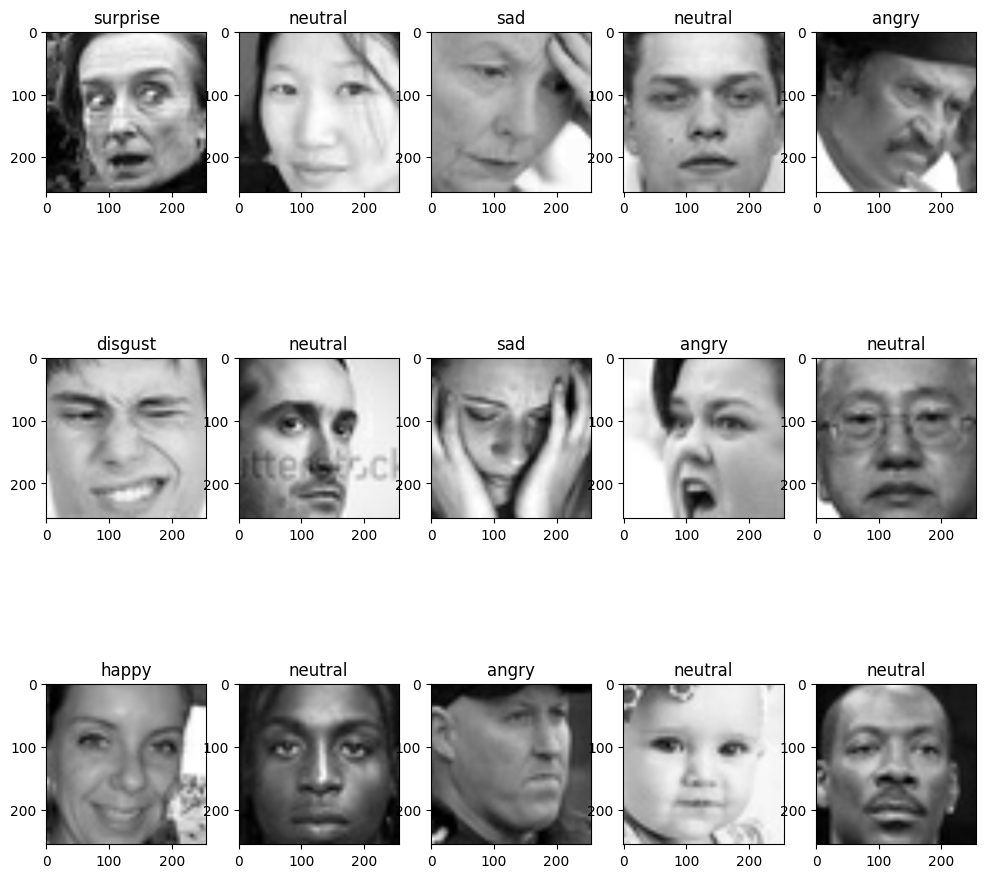

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i]/255., cmap='gray')
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0). numpy()])
    plt.axis("on")

In [11]:
training_dataset ={
    train_dataset
    .prefetch(tf.data.AUTOTUNE)

}

In [12]:
validation_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [13]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    Rescaling (1./255),

])

In [14]:
#Resnet architecture
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

In [15]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

In [16]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [17]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

In [18]:
loss_function = CategoricalCrossentropy()

In [19]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [20]:
resnet_34.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics)

In [22]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

def conv_block(input_tensor, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(input_tensor, filters, kernel_size):
    x = conv_block(input_tensor, filters, kernel_size)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return Add()([x, input_tensor])

def build_resnet(input_shape=(256, 256, 1), num_classes=7):
    input_tensor = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', name='conv1')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # First convolutional block
    x = conv_block(x, 64, (3, 3))
    x = identity_block(x, 64, (3, 3))
    x = identity_block(x, 64, (3, 3))

    # Second convolutional block
    x = conv_block(x, 128, (3, 3), strides=(2, 2))
    x = identity_block(x, 128, (3, 3))
    x = identity_block(x, 128, (3, 3))
    x = identity_block(x, 128, (3, 3))

    # Third convolutional block
    x = conv_block(x, 256, (3, 3), strides=(2, 2))
    x = identity_block(x, 256, (3, 3))
    x = identity_block(x, 256, (3, 3))
    x = identity_block(x, 256, (3, 3))
    x = identity_block(x, 256, (3, 3))
    x = identity_block(x, 256, (3, 3))

    # Fourth convolutional block
    x = conv_block(x, 512, (3, 3), strides=(2, 2))
    x = identity_block(x, 512, (3, 3))
    x = identity_block(x, 512, (3, 3))

    # Global average pooling and output layer
    x = GlobalAveragePooling2D()(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)

    return model

# Build the ResNet model
resnet_34 = build_resnet()

# Compile the model
resnet_34.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])
#train the model
history = resnet_34.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=1,
    verbose=1
)


70/70 [==============================] - 1915s 27s/step - loss: 2.1878 - accuracy: 0.1879 - val_loss: 15793.5410 - val_accuracy: 0.1446


In [23]:
import inspect

# Get the current frame
frame = inspect.currentframe()

# Get the filename of the module that contains the current frame
module_filename = inspect.getfile(frame)

# Extract the directory path from the module filename
model_path = os.path.dirname(module_filename)

# Define the model filename
model_filename = "my_model.h5"

# Combine the directory path and model filename to get the model path
model_path = os.path.join(model_path, model_filename)

print(f"Model path: {model_path}")

Model path: my_model.h5


In [24]:
# Import necessary libraries
from google.colab import drive

# Define the path to your trained model file
model_path = 'my_model.h5'  # Replace with your actual model path

# Mount your Google Drive
drive.mount('/content/drive')

# Define the destination path on your Google Drive
destination_path = '/content/drive/MyDrive/my_model.h5'  # Replace with your desired path

# Copy the model file to your Google Drive
!cp {model_path} {destination_path}

print("Model uploaded successfully to Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat 'my_model.h5': No such file or directory
Model uploaded successfully to Google Drive.


In [27]:
!pip install tf_explain
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tf_explain.core.grad_cam import GradCAM

# Load your trained model (assuming it's a Keras model)
model = tf.keras.models.load_model('/content/drive/MyDrive/Untitled3.ipynb')

# Load the image from Google Drive
image_path = '/content/drive/MyDrive/microexpressions/testing/sad/PrivateTest_11574818.jpg'  # Adjust the path to your image
image = Image.open(image_path)
image = image.resize((256, 256))  # Resize the image to match the input size expected by your model

# Preprocess the image
image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Get the predicted class
predictions = model.predict(image)
predicted_class = np.argmax(predictions[0])
predicted_label = "Class " + str(predicted_class)  # Change this according to your class labels

# Create a GradCAM explainer
explainer = GradCAM()

# Explain the prediction for the image
grid = explainer.explain((image, None), model, class_index=predicted_class)

# Plot the original image and GradCAM heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image[0])
ax1.set_title('Original Image')
ax1.axis('off')
ax2.imshow(image[0])
ax2.imshow(grid, cmap='jet', alpha=0.5)
ax2.set_title('GradCAM Heatmap for ' + predicted_label)
ax2.axis('off')
plt.show()


OSError: No file or directory found at /content/drive/MyDrive/Untitled3.ipynb